In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from skimage import color
from skimage import io
from skimage.transform import rescale, resize
import numba
from numba import jit

The heat equation $$\alpha \nabla^2 u = \frac{\partial u}{ \partial t}$$

* $u$ is temperature
* $\alpha$ is the thermal diffusivity
* $t$ is time

in two dimensions and in discrete form, can be written as

$$\alpha \left( \frac{u_{i+1,j}^{(m)} -2u_{i,j}^{(m)} + u_{i-1,j}^{(m)}}{\Delta x^2} + \frac{u_{i,j+1}^{(m)} -2u_{i,j}^{(m)} + u_{i,j-1}^{(m)}}{\Delta y^2}\right) = \frac{u_j^{(m+1)} - u_j^{(m)}}{\Delta t} $$ 

Can rearrange to solve for $m+1$ 

$$ u_j^{(m+1)} = u_j^{(m)} + \alpha \frac{\Delta t}{\Delta x^2} \left( u_{i+1,j}^{(m)} + u_{i-1,j}^{(m)} +  u_{i,j+1}^{(m)} + u_{i,j-1}^{(m)}  -4u_{i,j}^{(m)} \right) $$

In [26]:
edge = np.linspace(0, 1, 100)
xv, yv = np.meshgrid(edge, edge)

Load image. Find locations of the turkey pixels in boolean 2d array

In [27]:
image = io.imread('turkey.png')[:,:,:3] # remove the transperency Alpha
image_resized = resize(
    image, (100, 100), anti_aliasing=True
)
img = color.rgb2gray(image_resized)
img = np.flip(img, axis=0)

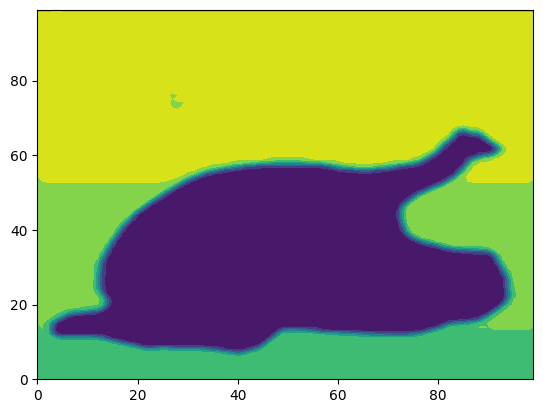

In [28]:
plt.contourf(img)

In [29]:
turkey_bool = img<0.5
is_cut_half = False
if is_cut_half:
  turkey_bool[30,:] = False 

Thermal diffusivity of the turkey:

In [30]:
a_turk = 1.32e-7

Oven and initial turkey temperature

In [31]:
rawturk_temp = 273.15 + 25 # in kelvin
oven_temp = 273.15 + 165

Set the turkey to the initial turkey temperature and the oven to the preheated oven temperature

In [32]:
init_heat = np.zeros([100,100]) + oven_temp
init_heat[turkey_bool] = rawturk_temp

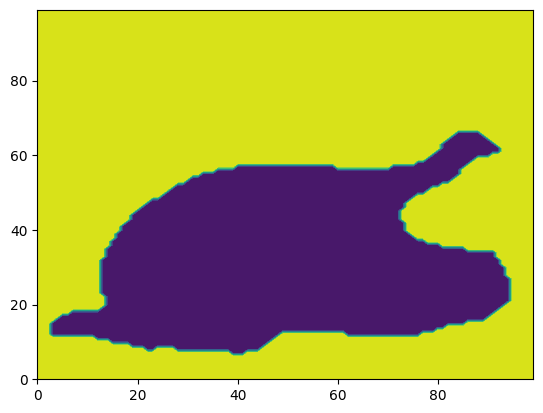

In [33]:
plt.contourf(init_heat)

Get 

* Number of differential equation update iterations `times`
* Number of snapshots we will take `times_snaphot`. 
* The array of snapshots we will take of the turkey


In [34]:
times = 36000
times_snapshot = 3600
f = int(times/times_snapshot)
heat_frames = np.zeros([times_snapshot, 100, 100])
heat_frames[0] = init_heat

In [35]:
f

10

Set the dimensions of the problem

In [36]:
x = 0.5 # 50 cm long
dx = 0.5/100
dt = 1

Compute $s = \alpha \Delta t / \Delta x^2$. $s$ needs to be much less than 1/4 for this to work.

In [37]:
a_turk * dt / dx**2

0.005279999999999999

Set up numba function

In [38]:
@numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True) # type&&size, nopython=compile, nogil=for_run_parallel
def solve_heat(heatmap, is_turkey):
    cs = heatmap[0].copy() #current state
    length = len(cs[0])
    cf = 0 # current frame
    for t in range(1,times):
        ns = cs.copy() # new state
        for i in range(1, length-1):
            for j in range(1, length-1):
                if is_turkey[j][i]: # calc only in the turky
                    a = a_turk
                    ns[j][i] = cs[j][i] + a*dt/dx**2 * (cs[j+1][i] + cs[j-1][i] +\
                                                    cs[j][i+1] + cs[j][i-1] -\
                                                    4*cs[j][i])
        cs = ns.copy()
        if t%f==0:
            cf = cf + 1
            heatmap[cf] = cs
            
    return heatmap

Get heat snapshots (in Kelvin)

In [39]:
heat_frames = solve_heat(heat_frames, turkey_bool)

Convert to celcius

In [40]:
heat_frames -= 273.15

Make heat plot of final snapshot

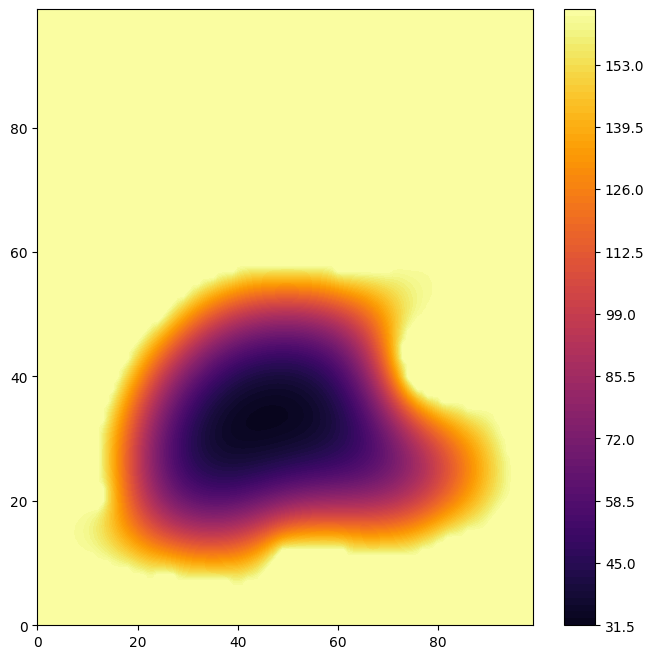

In [41]:
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
a = plt.contourf(heat_frames[1000], 100, cmap=my_cmap, vmin=rawturk_temp-273.15, vmax=oven_temp-273.15)
plt.colorbar(a)

Make animation

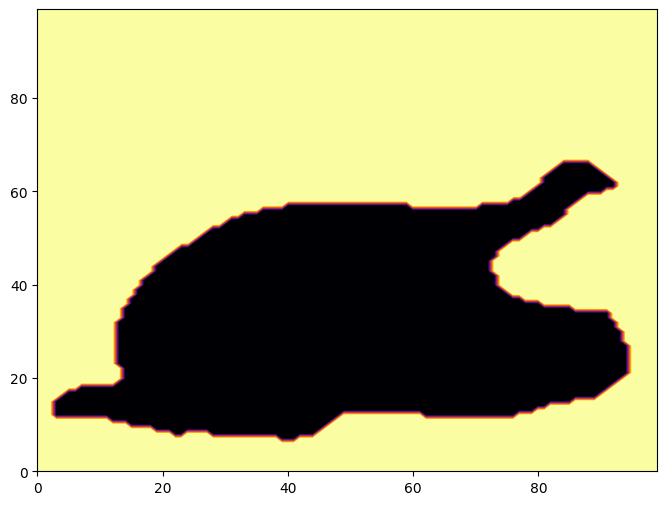

In [42]:
def animate(i):
    ax.clear()
    ax.contourf(heat_frames[10*i], 100, cmap=my_cmap, vmin=rawturk_temp-273.15, vmax = oven_temp-273.15)

    return fig,

fig, ax = plt.subplots(figsize=(8,6))
ani = animation.FuncAnimation(fig, animate,
                               frames=359, interval=50)
image_name = 'cooked_half.gif' if is_cut_half else 'cooked_full.gif'
ani.save(image_name ,writer='pillow',fps=30)

Examine a few quantities

In [43]:
t = np.linspace(0, 10, len(heat_frames))

In [44]:
avg_temp = np.array([heat_frame[turkey_bool].mean() for heat_frame in heat_frames]) 
min_temp = np.array([heat_frame[turkey_bool].min() for heat_frame in heat_frames]) 
std_temp = np.array([heat_frame[turkey_bool].std() for heat_frame in heat_frames]) 

Plot

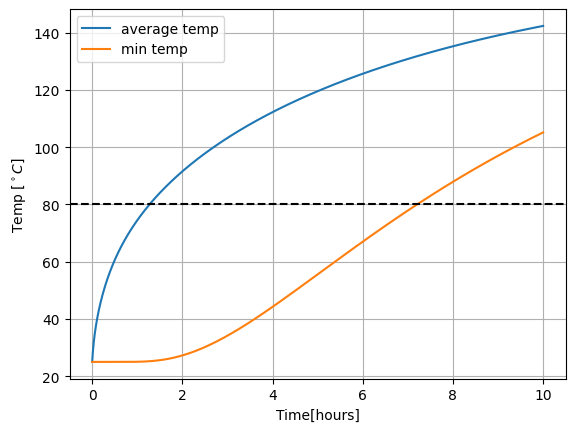

In [46]:
plt.plot(t, avg_temp, label='average temp')
plt.plot(t, min_temp, label='min temp')
plt.axhline(80, color='k', ls='--')
plt.xlabel('Time[hours]')
plt.ylabel('Temp [$^\circ C$]')
plt.legend()
plt.grid()